In [33]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import time

from qiskit import BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua import QuantumInstance, set_qiskit_aqua_logging
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Pauli
from qiskit.optimization.ising import max_cut, tsp
from qiskit.optimization.ising.common import sample_most_likely

import logging

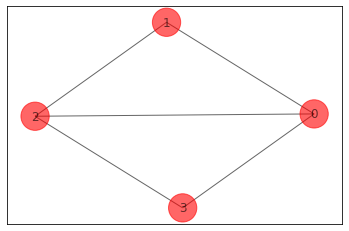

In [2]:
# generate a graph

n = 4
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
E = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
G.add_weighted_edges_from(E)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

In [3]:
# build a weight matrix from G
w = np.zeros([n,n])
for i, j, data in G.edges.data():
    w[i][j] = data['weight']
    w[j][i] = data['weight']
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


#### Convert adjacency matrix to Hamiltonians

Example listed [here](https://medium.com/qiskit/the-variational-quantum-eigensolver-43f7718c2747). For a given edge, the two nodes being connected will be represented with Z and others X. 

In [4]:
from qiskit.quantum_info import Pauli
ixzy = Pauli([True, True, False, False], [True, False, True, False])
print(ixzy)   # How we define gates

IXZY


In [5]:
def adj2paulis(adjM):
    n = adjM.shape[0]  # num nodes
    paulis = []
    offset = 0
    for i in range(n):
        for j in range(i):
            if adjM[i, j] != 0:
                x_p = np.zeros(n, dtype=np.bool)  
                z_p = np.zeros(n, dtype=np.bool)
                z_p[i], z_p[j] = True, True  
                paulis.append([0.5 * adjM[i,j], Pauli(z_p, x_p)])
                offset -= 0.5 * adjM[i, j]
    return WeightedPauliOperator(paulis=paulis), offset

In [6]:
wpo, offset = adj2paulis(w)
print(wpo.print_details())
print("offset: ", offset)
print(wpo.to_dict())

IIZZ	(0.5+0j)
IZIZ	(0.5+0j)
IZZI	(0.5+0j)
ZIIZ	(0.5+0j)
ZZII	(0.5+0j)

offset:  -2.5
{'paulis': [{'label': 'IIZZ', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'IZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'IZZI', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'ZIIZ', 'coeff': {'real': 0.5, 'imag': 0.0}}, {'label': 'ZZII', 'coeff': {'real': 0.5, 'imag': 0.0}}]}


In [7]:
def weightedPaulisToPaulis(wpo):
    """
    @param wpo: Weighted PauliOperator
    @return ps: Pauli Operator list
        [(label, coeff, pauli object), ...]
        will use the pauli object to instruction for circuit building
    """
    ps = []
    wpos = wpo.to_dict()['paulis']
    for d in wpos:
        label, coeff = d['label'], d['coeff']['real']
        pauli = Pauli(label=label)
        ps.append((label, coeff, pauli))
    return ps

In [8]:
wpo.to_dict()['paulis'][0]
Pauli(label='IZIZ')

Pauli(z=[True, False, True, False], x=[False, False, False, False])

In [9]:
wpo.to_dict()

{'paulis': [{'label': 'IIZZ', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IZIZ', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'IZZI', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'ZIIZ', 'coeff': {'real': 0.5, 'imag': 0.0}},
  {'label': 'ZZII', 'coeff': {'real': 0.5, 'imag': 0.0}}]}

In [10]:
weightedPaulisToPaulis(wpo)

[('IIZZ',
  0.5,
  Pauli(z=[True, True, False, False], x=[False, False, False, False])),
 ('IZIZ',
  0.5,
  Pauli(z=[True, False, True, False], x=[False, False, False, False])),
 ('IZZI',
  0.5,
  Pauli(z=[False, True, True, False], x=[False, False, False, False])),
 ('ZIIZ',
  0.5,
  Pauli(z=[True, False, False, True], x=[False, False, False, False])),
 ('ZZII',
  0.5,
  Pauli(z=[False, False, True, True], x=[False, False, False, False]))]

#### Exact Answer
---

In [11]:
ee = ExactEigensolver(wpo, k=1)
result = ee.run()
print("the ground state energy: ", result["energy"])

the ground state energy:  -1.5


#### Approximator

In [192]:
# Im gonna go for a custom one, but may need to use something like RY from
# from qiskit.aqua.components.variational_forms import RY


def prep_ansantz(qc, params):
    q = qc.qregs[0]  # take the quantum register out
    n = q.size
    try:
        assert(len(params) == 2*n)
    except:
        raise ValueError("Not enough parameters, need ", len(params))
    for i in range(n):
        qc.rx(params[2*i], q[i])
        qc.ry(params[2*i+1], q[i])
        
    for i in range(n):
        if i < n-1:
            qc.cnot(q[i], q[i+1])
    return qc


def vqe_circuit(n, params, pauli_label):
    qr = QuantumRegister(n)
    cr = ClassicalRegister(n)
    qc = QuantumCircuit(qr, cr)
    qc = prep_ansantz(qc, params)
    qc.barrier()
    # add the pauli
#     pauli = Pauli(label=pauli_label)
#     qc.append(pauli.to_instruction(), range(n), range(n))

    for i, gate in enumerate(pauli_label):
        if gate == 'Z':
            qc.z(qr[i])
    
#     # add measurements?
#     qc.measure(qr[0], cr[0])
    qc.barrier()
    for i in range(n):
        qc.measure(qr[i], cr[i])
    return qc

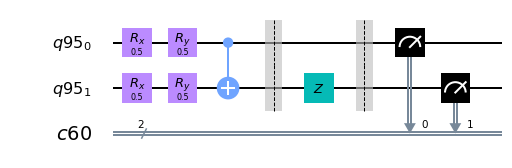

In [193]:
vqe_qc = vqe_circuit(2, [0.5, 0.5]*2, 'IZ')
vqe_qc.draw(output='mpl')

In [194]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(vqe_qc, backend, shots=1000)
result = job.result()
counts = result.get_counts()

In [195]:
counts

{'10': 94, '11': 111, '00': 786, '01': 9}